In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [13]:
# Show Columns
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date = session.query(func.max(Measurement.date)).first()
date


('2017-08-23')

In [16]:
year_ago = dt.datetime.strptime(date[0], '%Y-%m-%d')
year_ago = dt.date(year_ago.year-1,year_ago.month,year_ago.day)
year_ago

datetime.date(2016, 8, 23)

In [17]:
# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp).dropna()
# Sort the dataframe by date
prcp_df = prcp_df.set_index('date').sort_index()
prcp_df.head(12)



,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


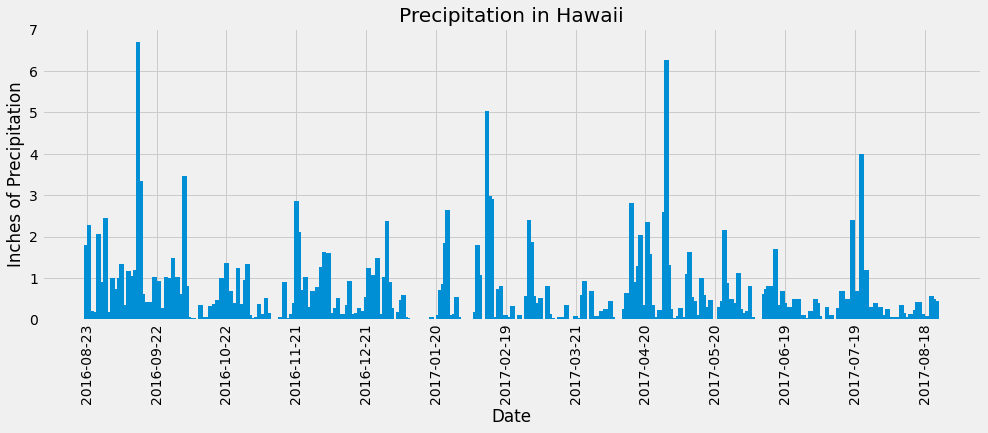

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
xaxis = prcp_df.index
yaxis = prcp_df.prcp.values

plt.figure(figsize=(15,5))
plt.bar(xaxis,yaxis, width=2)
plt.xticks(ticks= np.arange(0,365,30), rotation = 90)
plt.ylabel("Inches of Precipitation")
plt.xlabel("Date")
plt.title("Precipitation in Hawaii")
plt.savefig("Images/bar-measurements.png", bbox_inches = "tight")

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station, Station.name).group_by(Station.station).all()
total_stations

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.station,Station.name, func.count(Measurement.prcp)).\
            filter(Station.station == Measurement.station).group_by(Station.name).\
            order_by((func.count(Measurement.prcp)).desc()).all()
active_stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Station.station == 'USC00519281').all()
temps_active_station

[(53.0, 87.0, 73.09795396419437)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
temp_query = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
temp = [temp for temp, in temp_query]


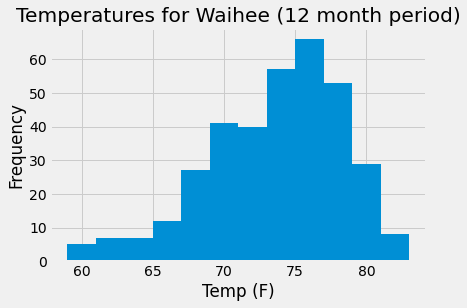

In [24]:
#plot the results as a histogram
plt.hist(temp, bins=12)
plt.title("Temperatures for Waihee (12 month period)")
plt.xlabel("Temp (F)")
plt.ylabel("Frequency")
plt.savefig("Images/histogram-station.png", bbox_inches = "tight")